# Description

This ipython notebook file maps french election data to a mercator projected heatmap. The tricky part is to map the city names to their latitude/longitudes, as various databases have various city names.

In [ ]:
# Download the french citites dataset
!curl http://freakonometrics.free.fr/popfr19752010.csv > population

# French cities per population


In [198]:
# Read the csv file
%clear
import csv
cities = []
with open('french_cities.csv') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        cities.append(r)

In [184]:
# Plot the population map (mostly to get comfortable with the basemap plotting API)
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import editdistance

def plot_france_locations(locations, vmin=None, vmax=None, scale='LogNorm', title=''):
    # create new figure, axes instances.
    fig=plt.figure(figsize=(20,20))
    ax=fig.add_axes([0.1,0.1,0.8,0.8])

    # setup mercator map projection.
    m = Basemap(llcrnrlon=-7.,llcrnrlat=40.,urcrnrlon=10.,urcrnrlat=53.,\
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',projection='merc',\
                lat_0=40.,lon_0=-20.,lat_ts=20.)
    m.drawcoastlines()
    m.fillcontinents()

    # draw parallels
    m.drawparallels(np.arange(10,90,2),labels=[1,1,0,1])
    # draw meridians
    m.drawmeridians(np.arange(-180,180,2),labels=[1,1,0,1])

    ax.set_title(title)

    # Prepare the data. We don't want the first row (titles)
    lats = [float(c[0]) for c in locations]
    lons = [float(c[1]) for c in locations]

    # We'll take the log, we better make this one >= 1.
    pops = [float(c[2])+1 for c in locations]
    maxpop = max(pops)

    # Normalize with regards to log of the population.
    if vmin is None:
        vmin = 1
    if vmax is None:
        vmax = max(pops)
    if scale is 'LogNorm':
        norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    # Do the actual plot.
    cmap = matplotlib.cm.get_cmap('hot')
    for pop, lat, lon in zip(pops, lats, lons):
        x,y = m(lat, lon)
        m.plot(x, y, '.', color=cmap(norm(pop)), markersize=5)
    # A colorbar. That was extremely painful. Thank you internet.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    plt.colorbar(sm)



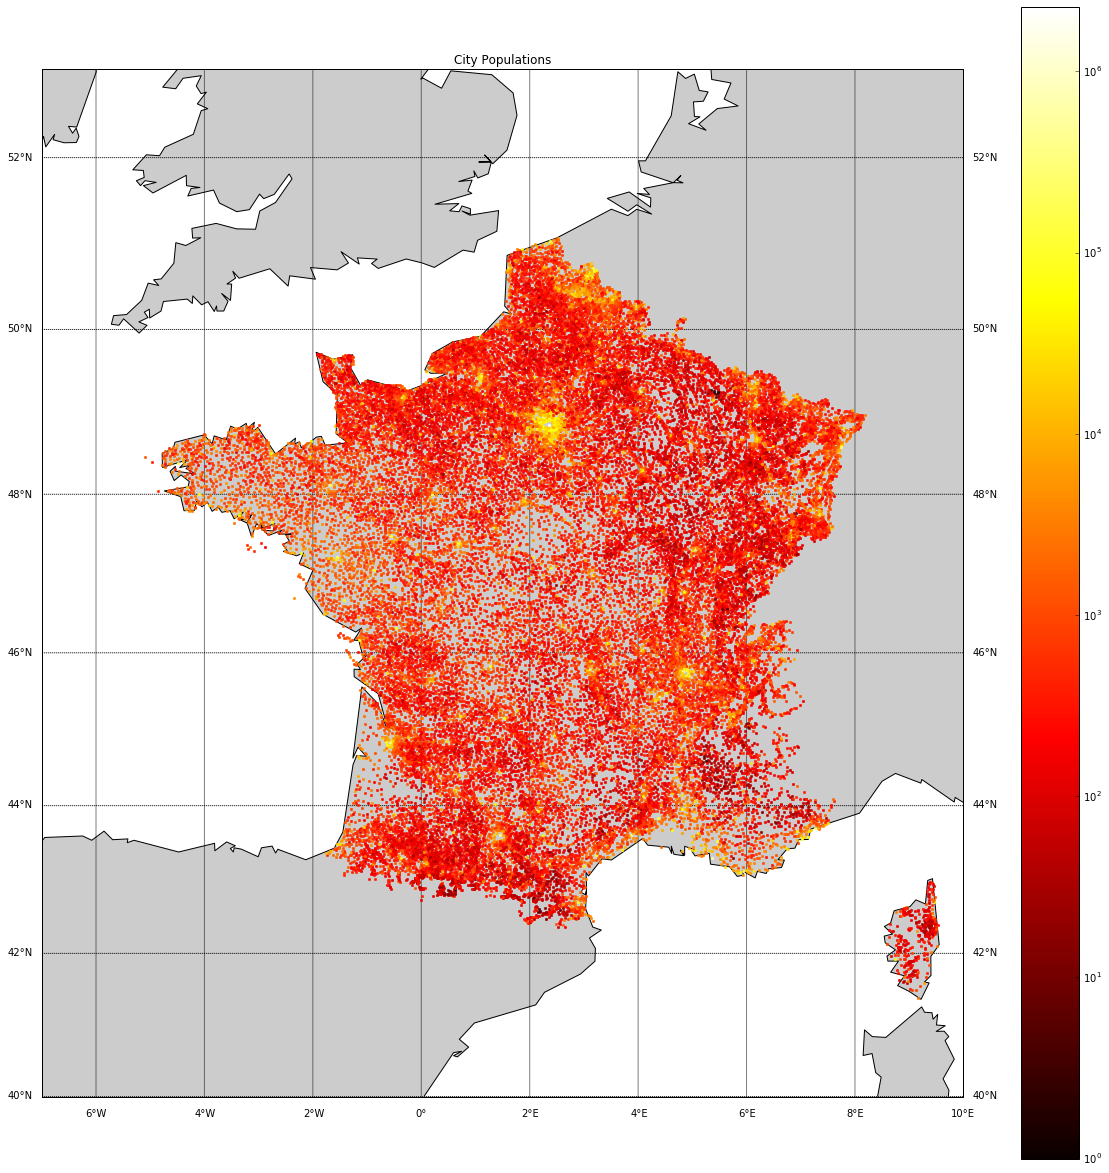

In [185]:
plot_france_locations([(c[5], c[6], c[8]) for c in cities[1:]], title='City Populations')

In [118]:
# Clean up the city keys. This code is pretty slow, so keep the
# normalized_latlons in memory and don't call the normalization 
# funciton often.

import unicodedata
import editdistance

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def normalize_city_to_latlon(elections, cities):
    city_dic = {}
    for c in cities[1:]:
        city_name = remove_accents(c[3].lower() + c[4].lower())
        city_dic[city_name] = (c[5], c[6])
    misses = 0
    city_names = city_dic.keys()
    city_to_latlon = {}
    for e in elections[1:]:
        try:
            city_name = remove_accents(e[3].lower())
            city_to_latlon[e[3]] = city_dic[city_name]
        except KeyError:
            distances = []
            for city in city_dic:
                distances.append((editdistance.eval(city, city_name), city))
            best_city = min(distances)
            if best_city[0] > 1:
                misses += 1
            else:
                city_to_latlon[e[3]] = city_dic[best_city[1]]
    return city_to_latlon

In [74]:
normalized_latlons = normalize_city_to_latlon(elections, cities)

# Presidentielles 2002

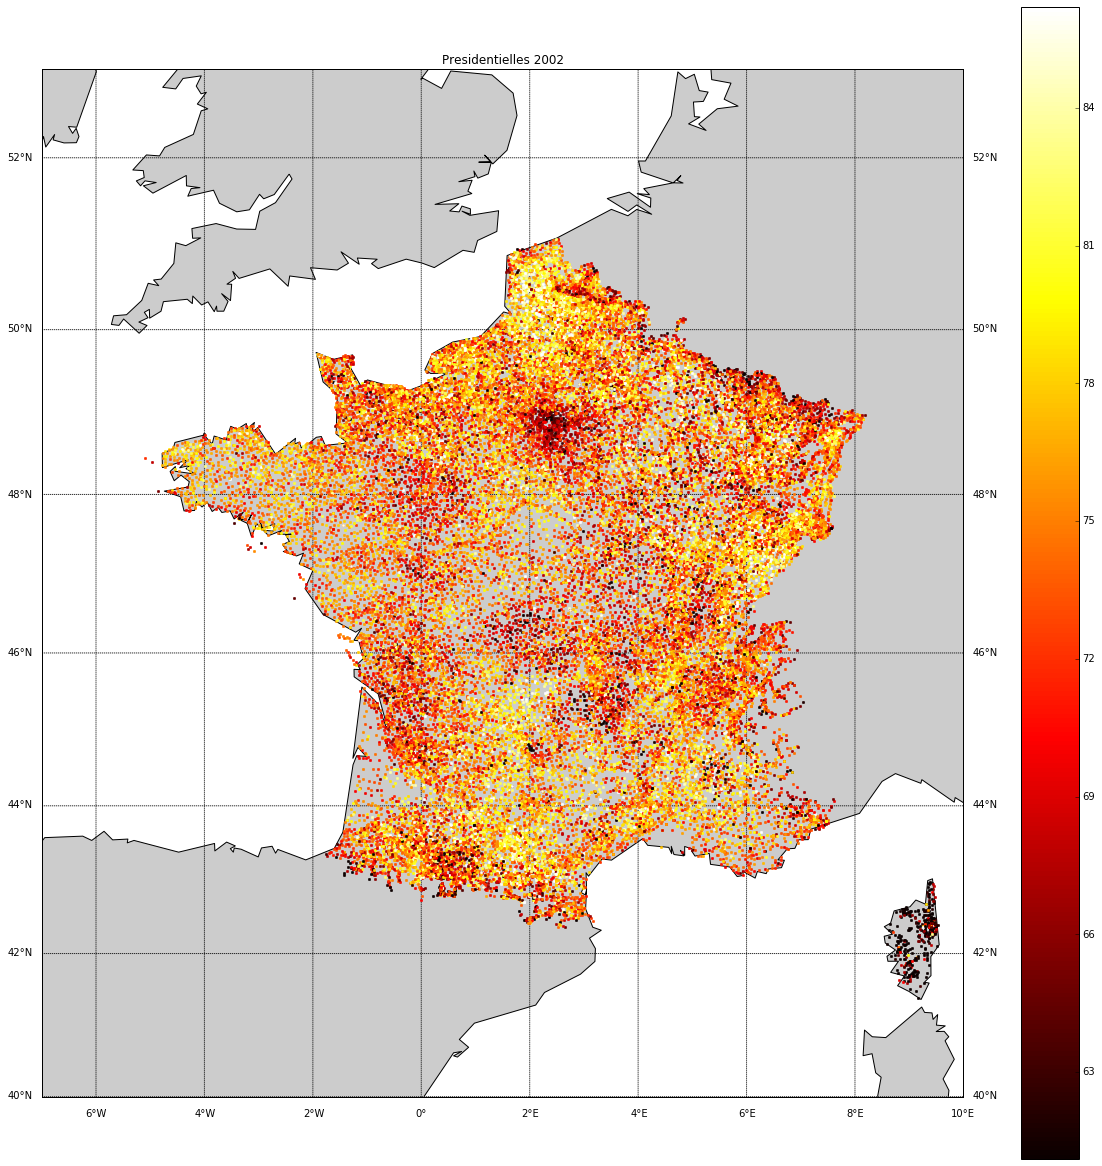

In [200]:
def plot_elections_participation(elections_data, title=''):
    PARTICIPATION_ID = 13
    CITY_ID = 3
    keys = list(normalized_latlons.keys())
    participations = [float(e[PARTICIPATION_ID]) for e in elections_data[1:]]

    latlon_val = []
    for e in elections_data[1:]:
        try:
            latlon_val.append(normalized_latlons[e[CITY_ID]] + (float(e[PARTICIPATION_ID]),))
        except KeyError:
            pass

    sigma = np.std(participations)
    mu = np.mean(participations)
    vmin = mu-2*sigma
    vmax = mu+2*sigma
    plot_france_locations(latlon_val, vmin, vmax, scale='Normalize', title=title)

elections_2002 = []
with open('presidentielles_data/presidentielles_2002_1ertour.csv.0') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        elections_2002.append(r)
        
plot_elections_participation(elections_2002, title='Presidentielles 2002')

# Presidentielles 2007

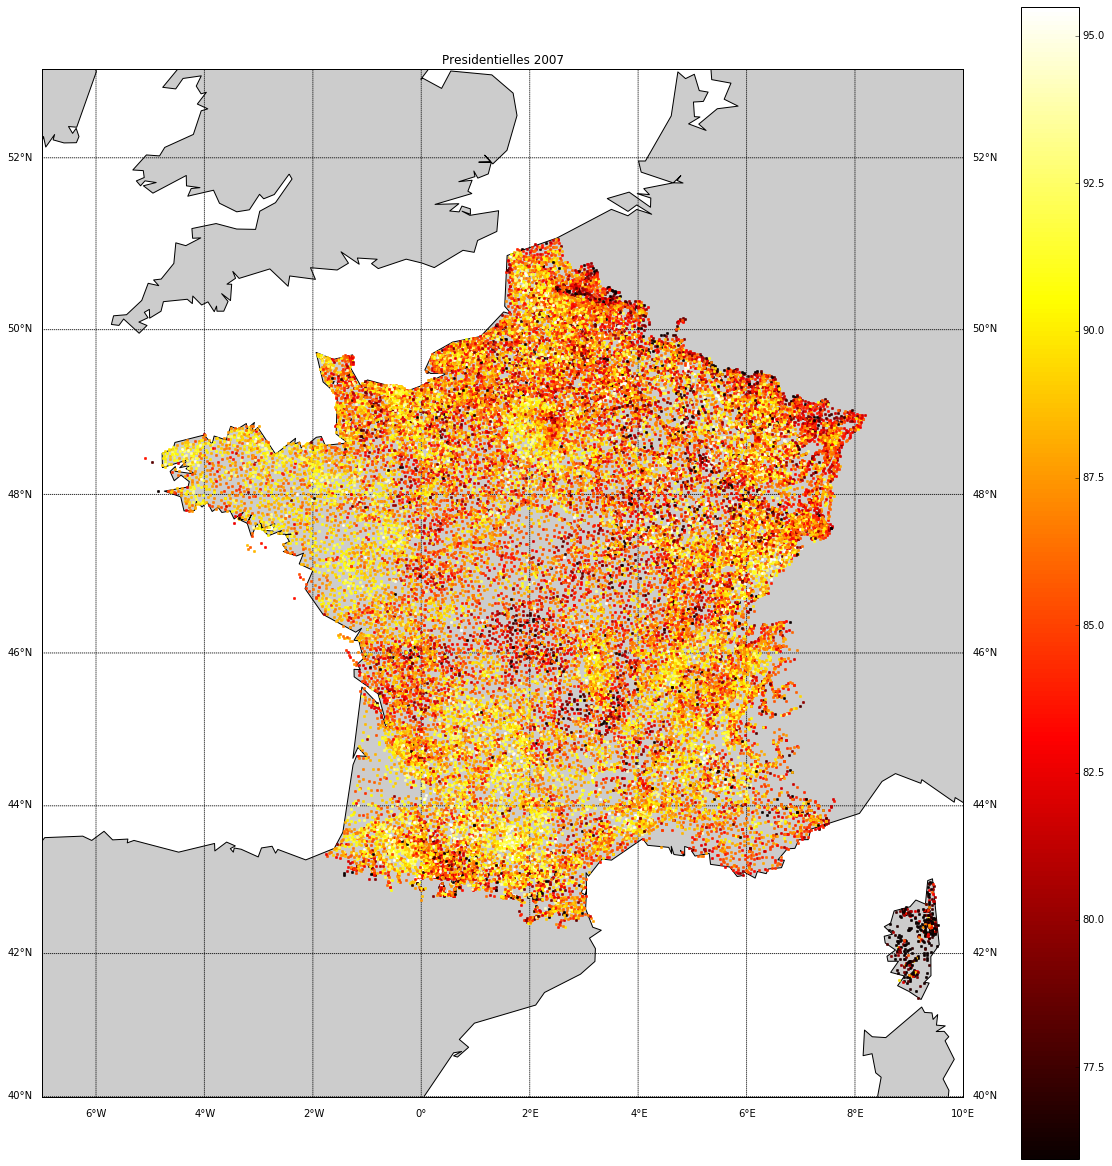

In [202]:
elections_2007 = []
with open('presidentielles_data/presidentielles_2007.csv.0') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        elections_2007.append(r)
plot_elections_participation(elections_2007, title='Presidentielles 2007')

# Presidentielles 2012

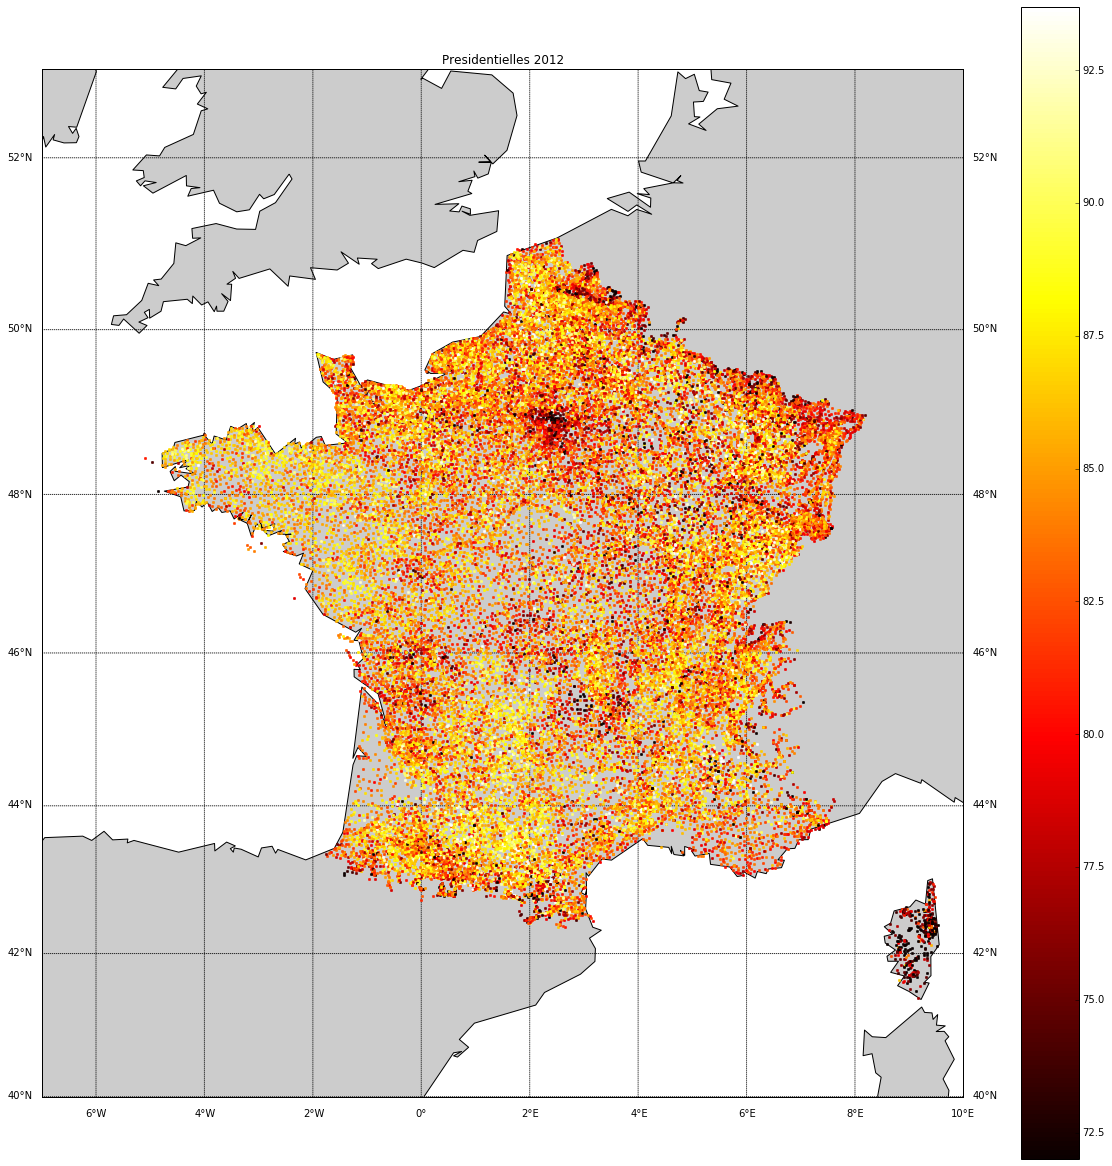

In [203]:
elections_2012 = []
with open('presidentielles_data/presidentielles_2012.csv.0') as f:
    csvreader = csv.reader(f)
    for r in csvreader:
        elections_2012.append(r)
plot_elections_participation(elections_2012, title='Presidentielles 2012')